Importing the basic libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transf
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

Setting up some basic paramters used in the model

In [2]:
epochs = 5
batchsize = 40
learnrate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   #checking the system available for use
print(device)

cuda


Transforms for converting the dataset image values to tensors with Data Augmentation and Resizing

In [3]:
trans_train = transf.Compose([
    transf.Resize(size=(224, 224)),         #this is the size of the input layer of the resnet50 model
    transf.RandomHorizontalFlip(),          #randomly flips an image
    transf.RandomRotation(10),              #randomly rotates an image
    transf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),      #changes brightness, contract and saturation levels of the images
    transf.ToTensor(),                      #transforms to a tensor
    transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])    #these are the values of the mean and standard deviation of RGB
trans_test = transf.Compose([
    transf.Resize(size=(224, 224)),
    transf.ToTensor(),
    transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

Downloading and Loading up the Training and Testing Data

In [4]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download= True, transform = trans_train)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download= True, transform = trans_test)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = batchsize, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = batchsize, shuffle = False)

100%|██████████| 170498071/170498071 [00:01<00:00, 101949100.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The classes in the CIFAR10 Dataset

In [5]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


Importing the pretrained Resnet50 model with its weights and finetuning the model for CIFAR10 dataset (Transfer Learning)

In [6]:
from torchvision.models import resnet50, ResNet50_Weights     #importing the model and its weights
weights = ResNet50_Weights.DEFAULT                            #setting our weights to the pretrained weights
model = resnet50(weights=weights)                             #setting our model to the pretrained resnet50 model
print(model.fc)                                               #checking the initial fully connected layer
inputlastlayer = model.fc.in_features
model.fc = nn.Linear(inputlastlayer, 10)                      #changing the output layer to have 10 outputs for the CIFAR10 Dataset
model = model.to(device)
print(model.fc)                                               #printing the altered fully connected layer
print(model)                                                  #checking the characteristics of the model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 49.6MB/s]


Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=10, bias=True)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

Formulating the Loss Function and Optimiser to update the parameters

In [7]:
loss_func = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr = learnrate, momentum = 0.9,weight_decay=5e-4) # weight decay helps prevent overfitting
total_step = len(train_dataloader)

Training the Model over for loops to improve the accuracy


In [8]:
for epoch in range(epochs):
   for i, (image , labels) in enumerate(train_dataloader):
          image = image.to(device)
          labels = labels.to(device)

          labels_hat = model(image)
          corrects = (labels_hat.argmax(axis=1)==labels).sum().item()
          loss_value = loss_func(labels_hat, labels)
          loss_value.backward()
          optimiser.step()
          optimiser.zero_grad()
          if (i+1) % 250 == 0:
            print(f'epoch {epoch+1}/{epochs}, step: {i+1}/{total_step}: loss = {loss_value:.5f}, acc = {100*(corrects/labels.size(0)):.2f}%')

epoch 1/5, step: 250/1250: loss = 0.42490, acc = 87.50%
epoch 1/5, step: 500/1250: loss = 0.28243, acc = 90.00%
epoch 1/5, step: 750/1250: loss = 0.49992, acc = 87.50%
epoch 1/5, step: 1000/1250: loss = 0.09776, acc = 97.50%
epoch 1/5, step: 1250/1250: loss = 0.42413, acc = 82.50%
epoch 2/5, step: 250/1250: loss = 0.24683, acc = 90.00%
epoch 2/5, step: 500/1250: loss = 0.16571, acc = 95.00%
epoch 2/5, step: 750/1250: loss = 0.04558, acc = 97.50%
epoch 2/5, step: 1000/1250: loss = 0.12725, acc = 97.50%
epoch 2/5, step: 1250/1250: loss = 0.08528, acc = 97.50%
epoch 3/5, step: 250/1250: loss = 0.11823, acc = 95.00%
epoch 3/5, step: 500/1250: loss = 0.04217, acc = 100.00%
epoch 3/5, step: 750/1250: loss = 0.17155, acc = 92.50%
epoch 3/5, step: 1000/1250: loss = 0.09264, acc = 97.50%
epoch 3/5, step: 1250/1250: loss = 0.23808, acc = 95.00%
epoch 4/5, step: 250/1250: loss = 0.05687, acc = 97.50%
epoch 4/5, step: 500/1250: loss = 0.03432, acc = 100.00%
epoch 4/5, step: 750/1250: loss = 0.0343

Evaluation of the Implemented Resnet50 Model

In [9]:
accurate = 0
total = 0

with torch.no_grad():
  for i, (testimages,testlabels) in enumerate(test_dataloader):
    testimages = testimages.to(device)
    testlabels = testlabels.to(device)
    predicted = model(testimages)
    labelspredicted = predicted.argmax(axis=1)
    accurate += (labelspredicted==testlabels).sum().item()
    total += testlabels.size(0)

print(f'Accuracy of the Resnet50 CNN on the 10000 test images is : {100 * accurate / total} %')

Accuracy of the Resnet50 CNN on the 10000 test images is : 95.11 %


Visualising some predictions

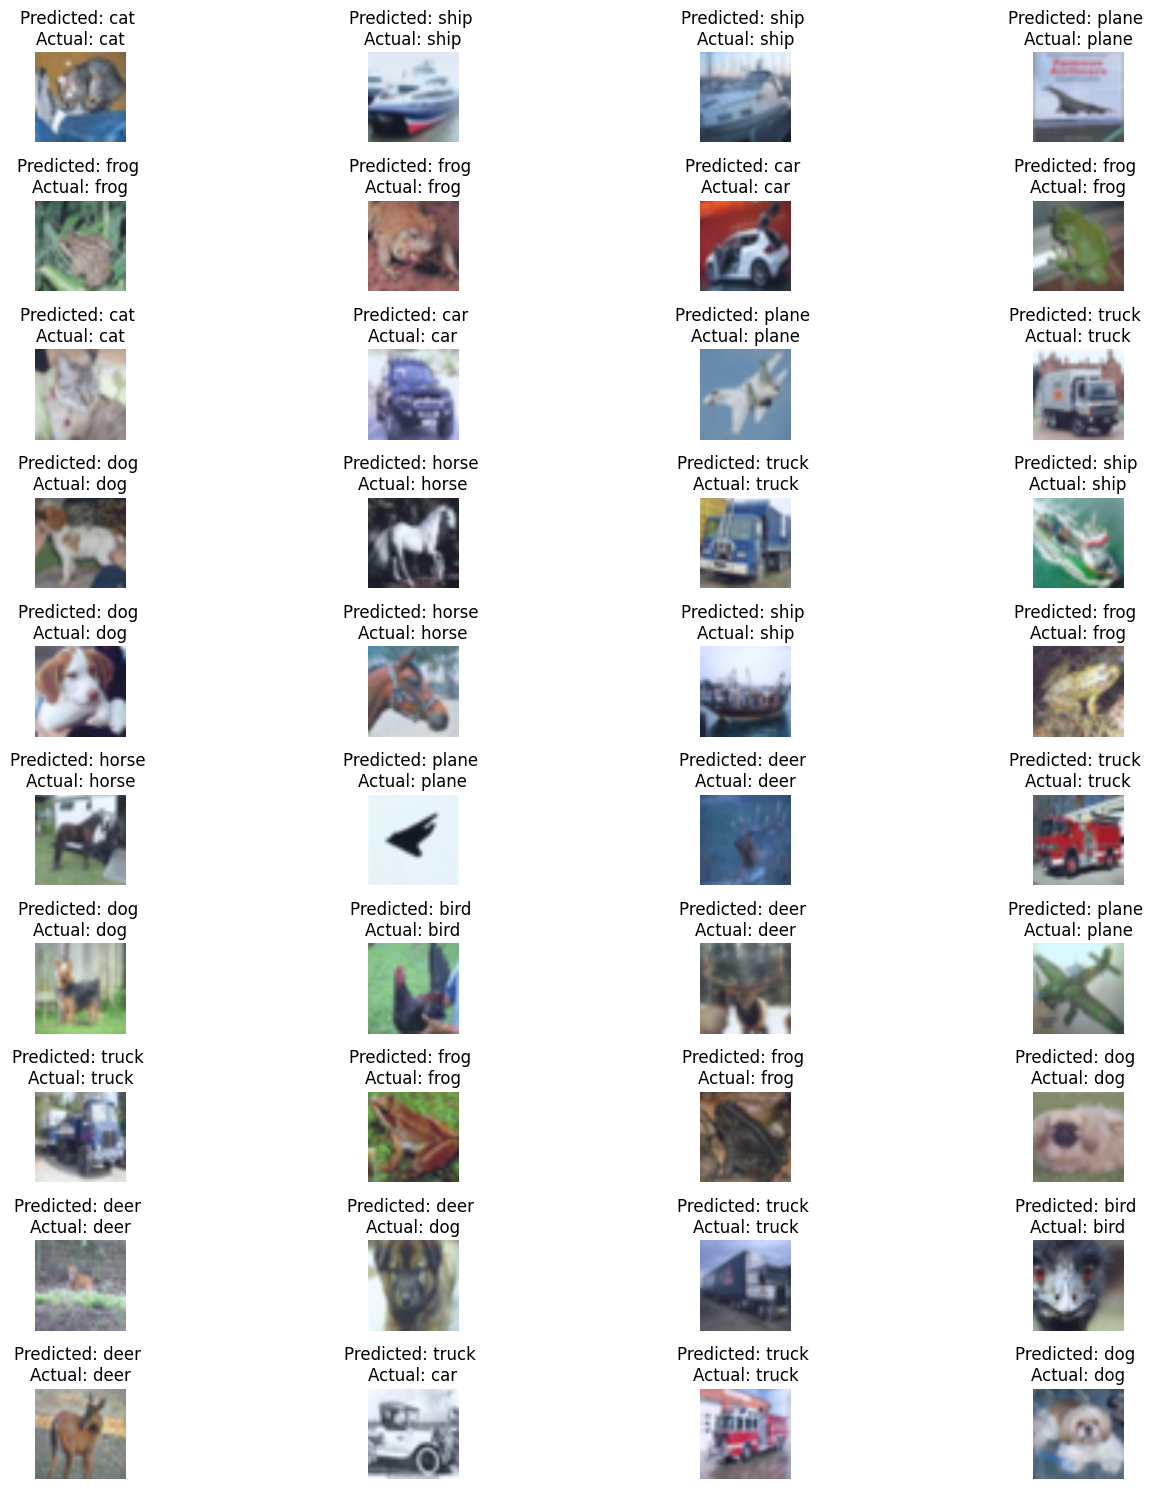

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, images, labels, classes):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        predicted = model(images)
        predicted_labels = predicted.argmax(dim=1).cpu().numpy()    #converting to a numpy array

    images = images.cpu().numpy() * 0.2 + 0.5  #Denormalize images
    images = np.transpose(images, (0, 2, 3, 1))  #(batch, channels, height, width) to (batch, height, width, channels)

    numimages = len(images)                 #will show the predcitions of one batch of images
    rows = int(np.ceil(numimages / 4))
    cols = min(4, numimages)

    plt.figure(figsize=(15,15))
    for i in range(numimages):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(f'Predicted: {classes[predicted_labels[i]]} \nActual: {classes[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

data_iterator = iter(test_dataloader)          #iterates through one batch of test data
images, labels = next(data_iterator)           #unpacks into labels and images
visualize_predictions(model, images, labels, classes)   #we call the function to view the predictions